# Navigation

---

## Brief introduction
In this notebook, I present my initial attempt to Project 1 in [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893). It is basically an adoption of the solution to the Deep Q-Network section exercise.

- _model.py_ defines the Network, it is unchanged from the said exercise, using 2 layers fully connected hidden layers with ReLU activation.
- _dqn_agent.py_ defines the Agent, it learns with the Classic Deep Q-Learning technique, with Experience Replay and delayed Target Network update techniques.

## Setting it all up
We begin by importing some necessary packages. 

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import torch
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

Loading the Banana Navigation enviroment by pointing the path to the EXE file in Windows.

In [2]:
env = UnityEnvironment(file_name=r"./Banana_Windows_x86_64/Banana.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Setting the Environment **_brain_**.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

checking the enviroment

In [4]:
# reset the environment
env_info = env.reset(train_mode=False)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


Trying with an un-trained agent - it does not take any action at all...

In [5]:
from dqn_agent import Agent

agent = Agent(state_size=37, action_size=4, seed=0)
env_info = env.reset(train_mode=False)[brain_name]
state = env_info.vector_observations[0]
score = 0
i = 0

while True:
    action = agent.act(state).item()
    env_info = env.step(action)[brain_name]
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break

print("Score: {}".format(score))

Score: 0.0


## Training
Training the agent, score>=16 as success. The success criteria is stricter than the project requirement, but just to try for fun.

In [6]:
from dqn_agent import Agent

agent = Agent(state_size=37, action_size=4, seed=0)

def dqn(brain_name, n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps).item()
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]   
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=16.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return scores

scores = dqn(brain_name)

Episode 100	Average Score: 1.17
Episode 200	Average Score: 4.36
Episode 300	Average Score: 7.39
Episode 400	Average Score: 9.16
Episode 500	Average Score: 13.02
Episode 600	Average Score: 14.30
Episode 700	Average Score: 14.35
Episode 800	Average Score: 15.06
Episode 900	Average Score: 14.78
Episode 993	Average Score: 16.00
Environment solved in 893 episodes!	Average Score: 16.00


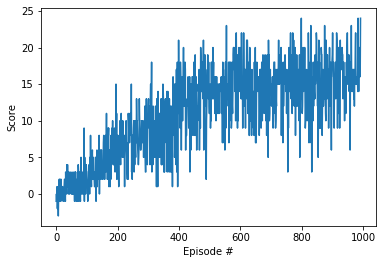

In [7]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

## See trained Agent in action

In [12]:
agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))
env_info = env.reset(train_mode=False)[brain_name]
state = env_info.vector_observations[0]
score = 0

while True:
    action = agent.act(state).item()
    env_info = env.step(action)[brain_name]
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break

print("Score: {}".format(score))

Score: 21.0


close the environment.

In [13]:
env.close()